In [112]:
#https://www.kaggle.com/code/alifvianmarco/covid-19-in-indonesia

import os
import numpy as np
import pandas as pd
import random
import seaborn as sns

import datetime as datetime
import matplotlib.dates as dates
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from contextlib import contextmanager
from time import time
from tqdm import tqdm
import lightgbm as lgbm

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline

import datetime
from datetime import date

In [94]:
df = pd.read_csv('covid_19_indonesia_time_series_all.csv')
df.head(20)

,Date,Location ISO Code,Location,New Cases,New Deaths,New Recovered,New Active Cases,Total Cases,Total Deaths,Total Recovered,...,Latitude,New Cases per Million,Total Cases per Million,New Deaths per Million,Total Deaths per Million,Total Deaths per 100rb,Case Fatality Rate,Case Recovered Rate,Growth Factor of New Cases,Growth Factor of New Deaths
0,3/1/2020,ID-JK,DKI Jakarta,2,0,0,2,39,20,41,...,-6.204699,0.18,3.60,0.00,1.84,0.18,51.28%,105.13%,NaN,NaN
1,3/2/2020,ID-JK,DKI Jakarta,2,0,0,2,41,20,41,...,-6.204699,0.18,3.78,0.00,1.84,0.18,48.78%,100.00%,1.0,1.0
2,3/2/2020,IDN,Indonesia,2,0,0,2,2,0,0,...,-0.789275,0.01,0.01,0.00,0.00,0.00,0.00%,0.00%,NaN,NaN
3,3/2/2020,ID-RI,Riau,1,0,0,1,2,0,3,...,0.511648,0.16,0.33,0.00,0.00,0.00,0.00%,150.00%,NaN,NaN
4,3/3/2020,ID-JK,DKI Jakarta,2,0,0,2,43,20,41,...,-6.204699,0.18,3.96,0.00,1.84,0.18,46.51%,95.35%,1.0,1.0
5,3/3/2020,IDN,Indonesia,0,0,0,0,2,0,0,...,-0.789275,0.00,0.01,0.00,0.00,0.00,0.00%,0.00%,0.0,1.0
6,3/3/2020,ID-JB,Jawa Barat,1,1,0,0,1,1,8,...,-6.920432,0.02,0.02,0.02,0.02,0.00,100.00%,800.00%,NaN,NaN
7,3/3/2020,ID-RI,Riau,0,0,0,0,2,0,3,...,0.511648,0.00,0.33,0.00,0.00,0.00,0.00%,150.00%,0.0,1.0
8,3/4/2020,ID-JK,DKI Jakarta,2,0,0,2,45,20,41,...,-6.204699,0.18,4.15,0.00,1.84,0.18,44.44%,91.11%,1.0,1.0
9,3/4/2020,IDN,Indonesia,0,0,0,0,2,0,0,...,-0.789275,0.00,0.01,0.00,0.00,0.00,0.00%,0.00%,1.0,1.0


In [97]:
data = df.drop(['City or Regency','Location ISO Code',
                'Province','Country','Continent','Island','Time Zone','Special Status',
                'Total Regencies','Total Cities','Total Districts','Total Urban Villages',
                'Total Rural Villages','New Cases per Million','Total Cases per Million',
                'New Deaths per Million','Total Deaths per Million','Case Fatality Rate',
                'Case Recovered Rate','Growth Factor of New Cases','Growth Factor of New Deaths','Total Deaths per 100rb'],axis = 1)
data = data.fillna(0)
data.head(5)

,Date,Location,New Cases,New Deaths,New Recovered,New Active Cases,Total Cases,Total Deaths,Total Recovered,Total Active Cases,Location Level,Area (km2),Population,Population Density,Longitude,Latitude
0,3/1/2020,DKI Jakarta,2,0,0,2,39,20,41,-22,Province,664,10846145,16334.31,106.836118,-6.204699
1,3/2/2020,DKI Jakarta,2,0,0,2,41,20,41,-20,Province,664,10846145,16334.31,106.836118,-6.204699
2,3/2/2020,Indonesia,2,0,0,2,2,0,0,2,Country,1916907,265185520,138.34,113.921327,-0.789275
3,3/2/2020,Riau,1,0,0,1,2,0,3,-1,Province,87024,6074100,69.80,101.805109,0.511648
4,3/3/2020,DKI Jakarta,2,0,0,2,43,20,41,-18,Province,664,10846145,16334.31,106.836118,-6.204699


In [117]:
data1 = data[data['Location Level'] != 'Country']
data1.head()


,Date,Location,New Cases,New Deaths,New Recovered,New Active Cases,Total Cases,Total Deaths,Total Recovered,Total Active Cases,Location Level,Area (km2),Population,Population Density,Longitude,Latitude
0,3/1/2020,DKI Jakarta,2,0,0,2,39,20,41,-22,Province,664,10846145,16334.31,106.836118,-6.204699
1,3/2/2020,DKI Jakarta,2,0,0,2,41,20,41,-20,Province,664,10846145,16334.31,106.836118,-6.204699
3,3/2/2020,Riau,1,0,0,1,2,0,3,-1,Province,87024,6074100,69.80,101.805109,0.511648
4,3/3/2020,DKI Jakarta,2,0,0,2,43,20,41,-18,Province,664,10846145,16334.31,106.836118,-6.204699
6,3/3/2020,Jawa Barat,1,1,0,0,1,1,8,-8,Province,35378,45161325,1276.55,107.603708,-6.920432


In [118]:
newest = data1.drop_duplicates(subset='Location', keep="last")
newest.head()


,Date,Location,New Cases,New Deaths,New Recovered,New Active Cases,Total Cases,Total Deaths,Total Recovered,Total Active Cases,Location Level,Area (km2),Population,Population Density,Longitude,Latitude
21364,11/21/2021,Gorontalo,1,0,0,1,11834,460,11374,0,Province,11257,1180651,104.88,122.376058,0.687003
21617,11/28/2021,Maluku Utara,2,0,3,-1,12101,303,11757,41,Province,31983,1307803,40.89,127.539107,0.212037
21700,12/1/2021,Bengkulu,1,0,0,1,23104,473,22612,19,Province,19919,1999539,100.38,102.338421,-3.533584
21712,12/1/2021,Kalimantan Utara,1,0,0,1,35885,811,35039,35,Province,75468,648407,8.59,116.218879,2.891013
21714,12/1/2021,Kepulauan Riau,2,0,0,2,53884,1748,52120,16,Province,8202,1929400,235.24,108.261746,3.916346


In [100]:
newest[newest.Location != 'Indonesia'].sort_values(by=['Total Cases'], ascending=False)

,Date,Location,New Cases,New Deaths,New Recovered,New Active Cases,Total Cases,Total Deaths,Total Recovered,Total Active Cases,Location Level,Area (km2),Population,Population Density,Longitude,Latitude
21733,12/2/2021,DKI Jakarta,28,0,0,28,864045,13596,849875,574,Province,664,10846145,16334.31,106.836118,-6.204699
21737,12/2/2021,Jawa Barat,83,0,6,77,707934,14737,692101,1096,Province,35378,45161325,1276.55,107.603708,-6.920432
21738,12/2/2021,Jawa Tengah,30,1,6,23,486435,30225,454837,1373,Province,32801,36364072,1108.64,110.201115,-7.259097
21739,12/2/2021,Jawa Timur,35,0,11,24,399478,29697,369537,244,Province,47803,40479023,846.78,112.732941,-7.723346
21743,12/2/2021,Kalimantan Timur,7,0,2,5,158245,5449,152714,82,Province,129067,3552191,27.52,116.468440,0.453858
21734,12/2/2021,Daerah Istimewa Yogyakarta,7,0,0,7,156769,5263,150965,541,Province,3133,3631015,1158.90,110.444878,-7.894502
21732,12/2/2021,Banten,16,0,1,15,132693,2688,129872,133,Province,9663,10722374,1109.64,106.109004,-6.456736
21750,12/2/2021,Riau,4,0,0,4,128825,4109,124123,593,Province,87024,6074100,69.80,101.805109,0.511648
21731,12/2/2021,Bali,15,1,1,13,114233,4046,110003,184,Province,5780,4216171,729.43,115.131714,-8.369472
21751,12/2/2021,Sulawesi Selatan,1,1,1,-1,109919,2238,107630,51,Province,46717,9426885,201.78,120.162056,-3.731081


In [102]:
data2 = data1[['New Deaths', 'New Cases','Total Cases', 'New Recovered', 'Total Recovered', 'Total Deaths','Population', 'Population Density']]
data2.head()

,New Deaths,New Cases,Total Cases,New Recovered,Total Recovered,Total Deaths,Population,Population Density
0,0,2,39,0,41,20,10846145,16334.31
1,0,2,41,0,41,20,10846145,16334.31
3,0,1,2,0,3,0,6074100,69.80
4,0,2,43,0,41,20,10846145,16334.31
6,1,1,1,0,8,1,45161325,1276.55


In [103]:
X = data2.drop('New Deaths', axis = 1)
y = data2['New Deaths']

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 41)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(15837, 7)
(5280, 7)
(15837,)
(5280,)


In [105]:
pipeline = Pipeline([
    ('std_scalar', StandardScaler())
])

X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

In [106]:
def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('__________________________________')

In [107]:
def predict_model(model, trainX, testX, trainY, testY):
    m = model
    m.fit(trainX, trainY)
    predict_m = m.predict(testX)
    print('-----------{}-----------'.format(model))
    print_evaluate(testY, predict_m)

In [113]:
model = [LinearRegression(),SVR()]
for i in model:
    predict_model(i, X_train,X_test, y_train, y_test)

-----------LinearRegression()-----------
MAE: 4.696335977769923
MSE: 318.4713316913107
RMSE: 17.845765091228525
R2 Square 0.561392549943972
__________________________________
-----------SVR()-----------
MAE: 4.214465771203115
MSE: 506.4296526626396
RMSE: 22.50399192727014
R2 Square 0.30253119674074314
__________________________________


MAE: 4.214465771203115
MSE: 506.4296526626396
RMSE: 22.50399192727014
R2 Square 0.30253119674074314
__________________________________


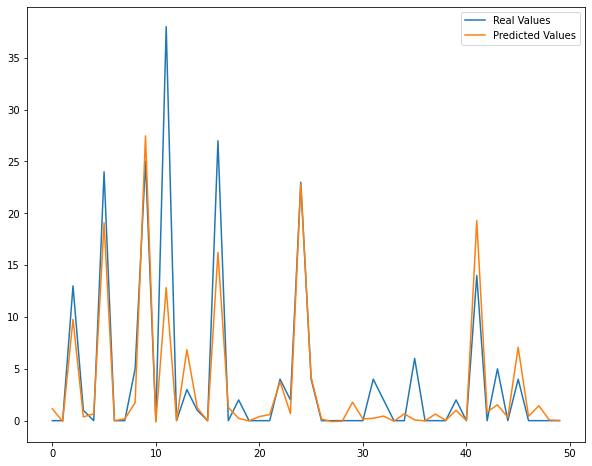

In [111]:
dct = SVR()
dct.fit(X_train, y_train)

pred_dct = dct.predict(X_test)
print_evaluate(y_test, pred_dct)

df_dct = pd.DataFrame({'Real Values':y_test, 'Predicted Values':pred_dct})
df_dct.head()

plt.figure(figsize=(10,8))
plt.plot(df_dct['Real Values'].values[:50], label = 'Real Values')
plt.plot(df_dct['Predicted Values'].values[:50], label = 'Predicted Values')
plt.legend()
plt.show()